In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

import credit as cde
import knearest_pipeline as kn
%matplotlib inline

os.chdir('/Users/mariomoreno/Desktop/Grad School/Machine Learning/Week 2')

# 1) Read Data

In [82]:
credit = cde.read_data('credit-data.csv')

First step is reading the data into a pandas dataframe and renaming the columns into more manageable names.

# 2) Explore Data

In [58]:
cde.explore_data(credit)


Top 5 and bottom 5 rows
   PersonID  experienced_90days_delinquency  use_unsecured_lines  age  \
0     98976                               0             1.000000   55   
1     98991                               0             0.547745   71   
2     99012                               0             0.044280   51   
3     99023                               0             0.914249   55   
4     99027                               0             0.026599   45   

   zipcode  times_30-59_pastdue  debt_ratio  monthly_income  \
0    60601                    0  505.000000             0.0   
1    60601                    0    0.459565         15666.0   
2    60601                    0    0.014520          4200.0   
3    60601                    4    0.794875          9052.0   
4    60601                    0    0.049966         10406.0   

   times_open_credit_loans  times_late  realestate_loans_lines  \
0                        2           0                       0   
1                        

PersonID                         -0.021010
experienced_90days_delinquency   -0.045051
use_unsecured_lines               0.006009
age                               0.005408
zipcode                           1.000000
times_30-59_pastdue              -0.002424
debt_ratio                        0.002088
monthly_income                   -0.004980
times_open_credit_loans          -0.009214
times_late                       -0.001487
realestate_loans_lines            0.003141
times_60-89_pastdue              -0.001198
dependents                       -0.001744
dtype: float64


Correlations for: times_30-59_pastdue

PersonID                         -0.082598
experienced_90days_delinquency    0.149334
use_unsecured_lines              -0.001999
age                              -0.068696
zipcode                          -0.002424
times_30-59_pastdue               1.000000
debt_ratio                       -0.011620
monthly_income                   -0.015224
times_open_credit_loans          -0.07070

The function above returns the head and tail of the dataframe, the summary stats for each variable, the value counts for each variable, the correlations between all the variables, and the variables with null values. 

In looking at the summary statistics, we observe a few values that might be outside the norm. In unsecured credit lines, someone has 22,000 lines of unsecured credit, somebody else has 106,885 debt ratio, while a third person is earning more than 1 million a month. 112 people have been 90 days late on their payments 112 times. These aren't necessarily outliers, but they do indicate a need to treat some of these variables differently. I will most likely end up discretizing monthly income to control for some of that variance, as well as age. I'll turn more than 90 days late into a binary variable, presumably since being late is what we care about moreso than times late.

In looking at the correlation, there's significant multicollinearity between times_30-59_pastdue, times_late, and times_60-89_pastdue. These are all very similar variables, so I will drop all but times_late

Histograms of all columns


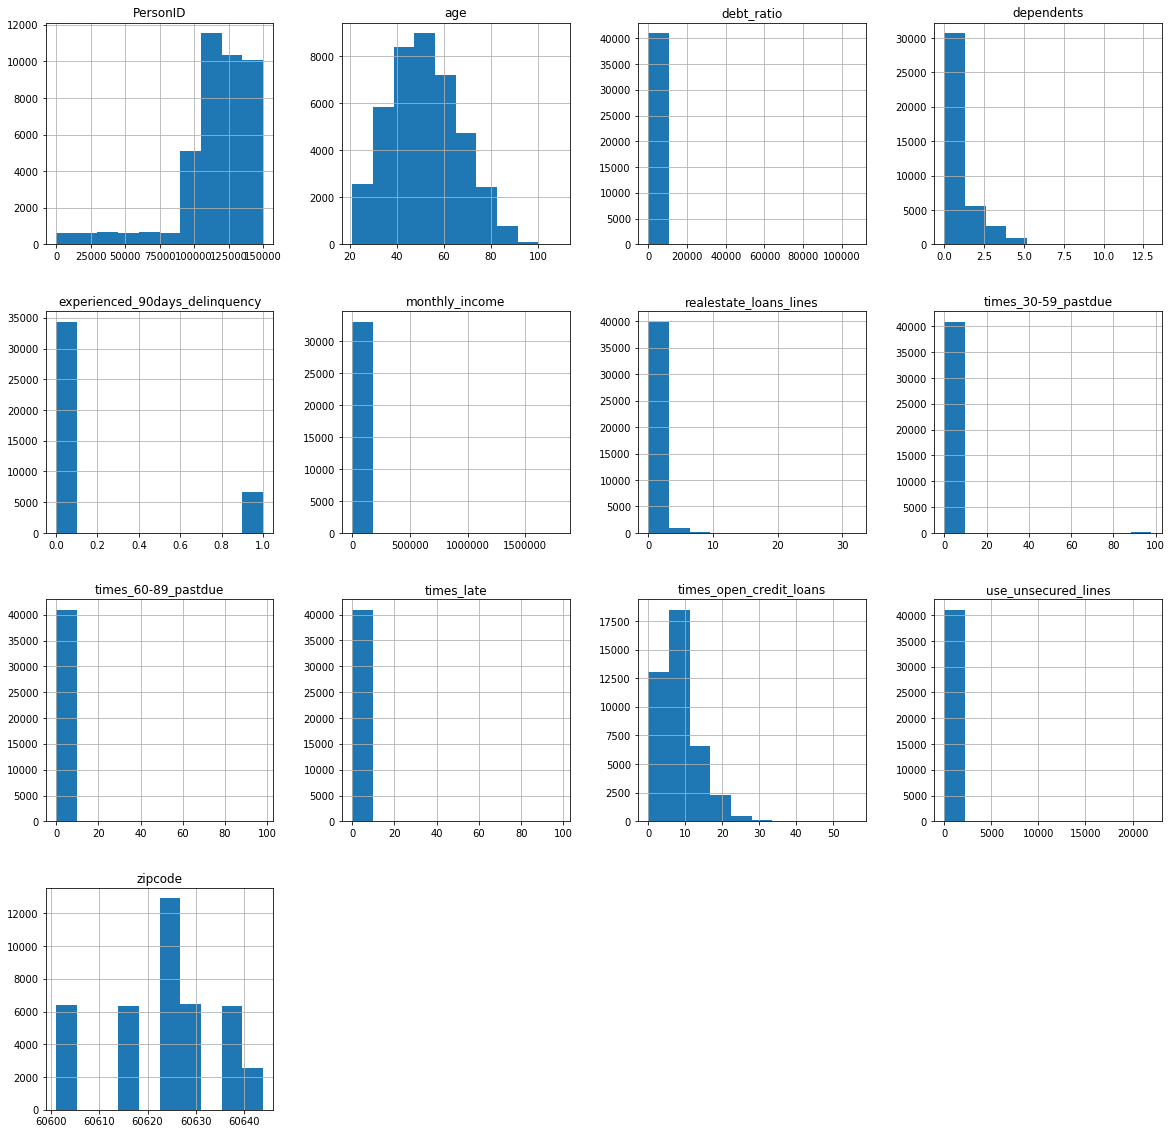

In [59]:
cde.plot_data(credit, 'hist', None, None)

Nothing too relevant to note from the histograms.

Scatter plot between PersonID and monthly_income


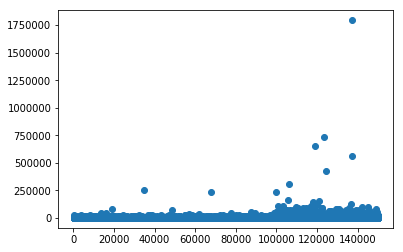

Scatter plot between experienced_90days_delinquency and monthly_income


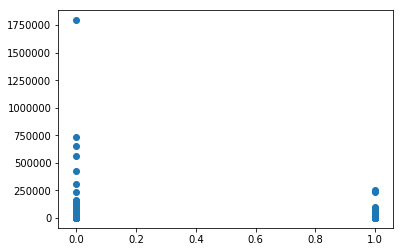

Scatter plot between use_unsecured_lines and monthly_income


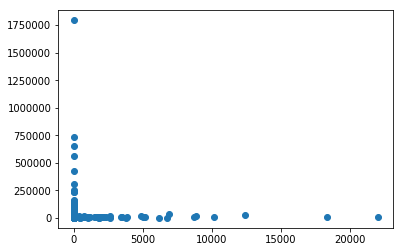

Scatter plot between age and monthly_income


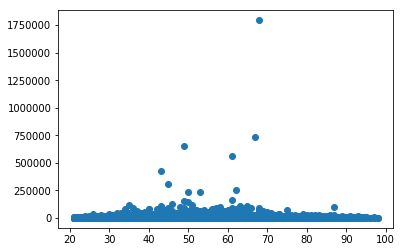

Scatter plot between zipcode and monthly_income


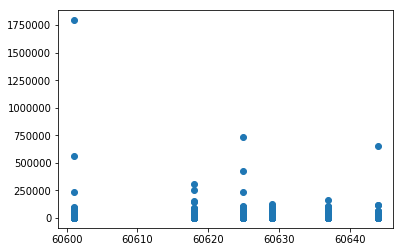

Scatter plot between times_30-59_pastdue and monthly_income


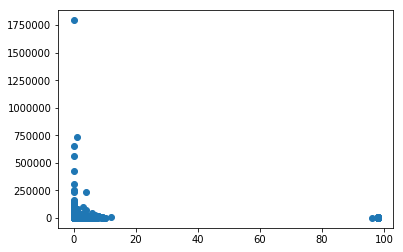

Scatter plot between debt_ratio and monthly_income


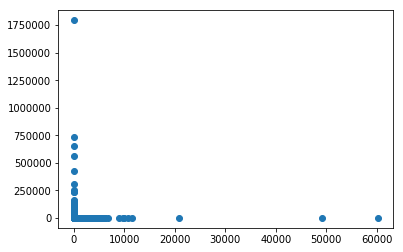

Scatter plot between times_open_credit_loans and monthly_income


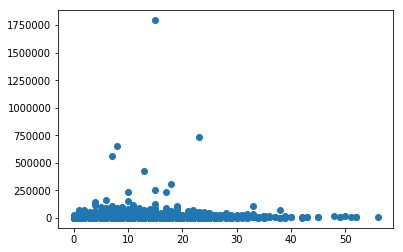

Scatter plot between times_late and monthly_income


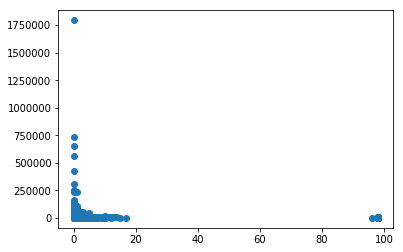

Scatter plot between realestate_loans_lines and monthly_income


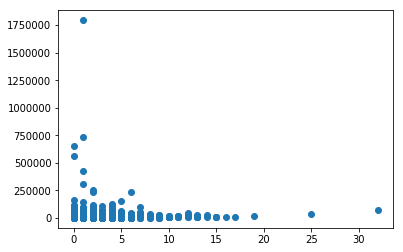

Scatter plot between times_60-89_pastdue and monthly_income


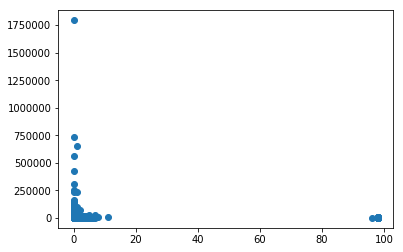

Scatter plot between dependents and monthly_income


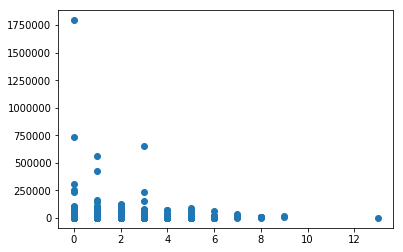

In [60]:
for column in credit:
    if column != 'monthly_income':
        cde.plot_data(credit, 'scatter', column, 'monthly_income')

The above graphs compare the relationship between monthly income and all the columns. Pretty standard results, including results such as the higher your income, the lower your debt ratio and the lower your income, the larger number of dependents.

Scatter plot between PersonID and debt_ratio


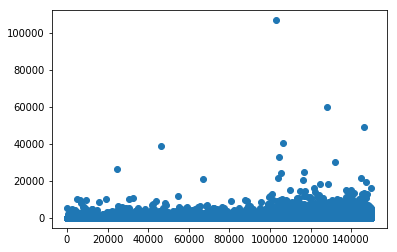

Scatter plot between experienced_90days_delinquency and debt_ratio


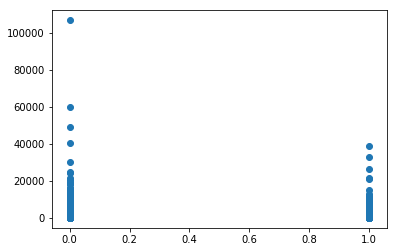

Scatter plot between use_unsecured_lines and debt_ratio


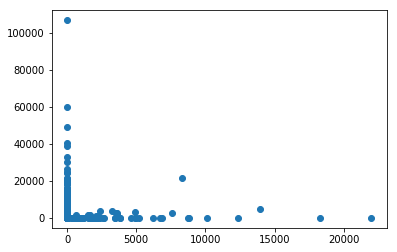

Scatter plot between age and debt_ratio


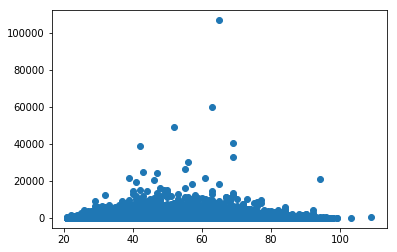

Scatter plot between zipcode and debt_ratio


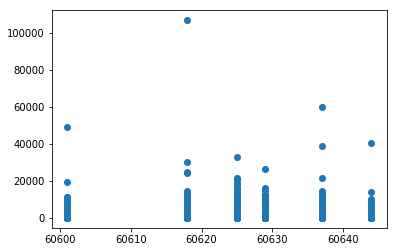

Scatter plot between times_30-59_pastdue and debt_ratio


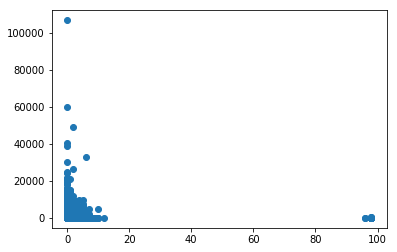

Scatter plot between monthly_income and debt_ratio


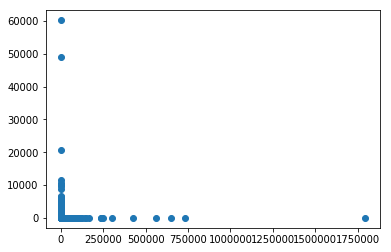

Scatter plot between times_open_credit_loans and debt_ratio


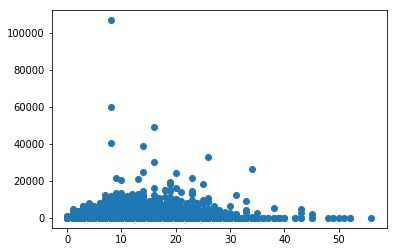

Scatter plot between times_late and debt_ratio


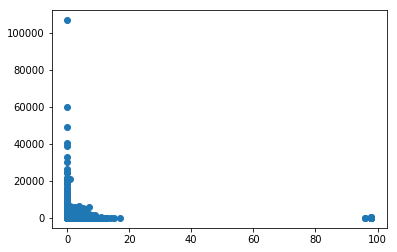

Scatter plot between realestate_loans_lines and debt_ratio


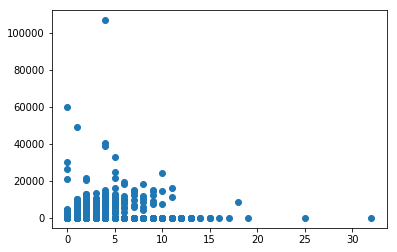

Scatter plot between times_60-89_pastdue and debt_ratio


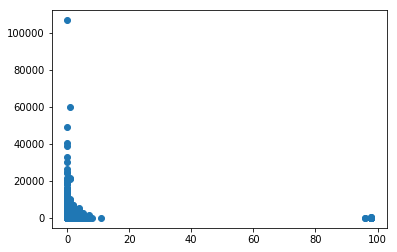

Scatter plot between dependents and debt_ratio


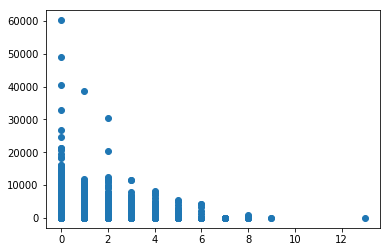

In [45]:
for column in credit:
    if column != 'debt_ratio':
        cde.plot_data(credit, 'scatter', column, 'debt_ratio')

Standard results here, as well.

Line graph between monthly_income and experienced_90days_delinquency


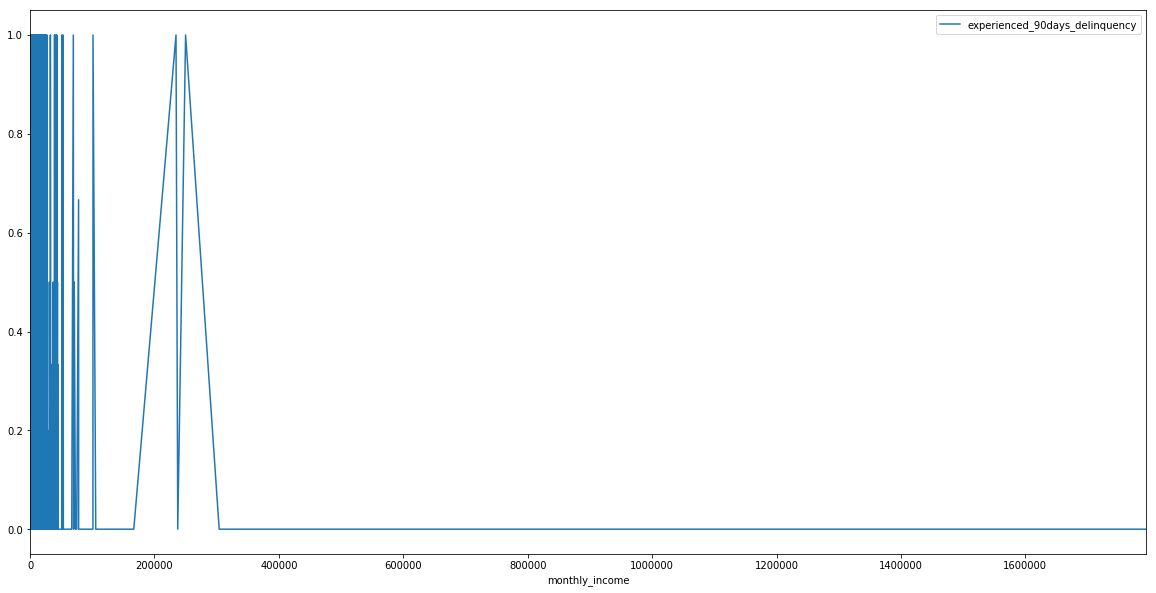

In [61]:
cde.plot_data(credit, 'line', 'monthly_income', 'experienced_90days_delinquency')

I'll need to run this again with discretized monthly income to get a sense of it's relation to 90 day delinquency.

# 3-4) Clean Data & Choose Features

In [62]:
clean_credit = cde.clean_data(credit)

In [63]:
clean_credit[:10]

,experienced_90days_delinquency,use_unsecured_lines,zipcode,debt_ratio,times_open_credit_loans,realestate_loans_lines,dependents,age_groups,monthly_income_groups,times_late_binary
0,0,1.000000,60601,505.000000,2,0,0.0,5.0,0.0,0
1,0,0.547745,60601,0.459565,7,2,0.0,7.0,1.0,0
2,0,0.044280,60601,0.014520,5,0,0.0,5.0,0.0,0
3,0,0.914249,60601,0.794875,12,3,0.0,5.0,0.0,0
4,0,0.026599,60601,0.049966,4,0,2.0,4.0,1.0,0
5,0,0.142231,60601,0.015332,6,0,0.0,5.0,1.0,0
6,0,0.047601,60601,0.474609,13,1,1.0,4.0,0.0,0
7,0,0.022141,60601,0.003332,2,0,1.0,3.0,0.0,0
8,0,0.241805,60601,0.864452,13,1,1.0,2.0,0.0,0
9,0,0.036181,60601,0.568798,16,2,0.0,7.0,0.0,0


Cleaned several aspects of the data and removed features that didn't seem important.

- Filled null values for monthly income and age, which had been identified in the data exploration process. Null values for monthly income were imputed with the mean. 

- Removed times_30-59_pastdue and times_60-89_pastdue, which were highly multicollinear with times_late.

- Discretized monthly income and age, and turned times_late into a binary variable

- Removed PersonID due to it's lack of explanatory power

Line graph between monthly_income_groups and experienced_90days_delinquency


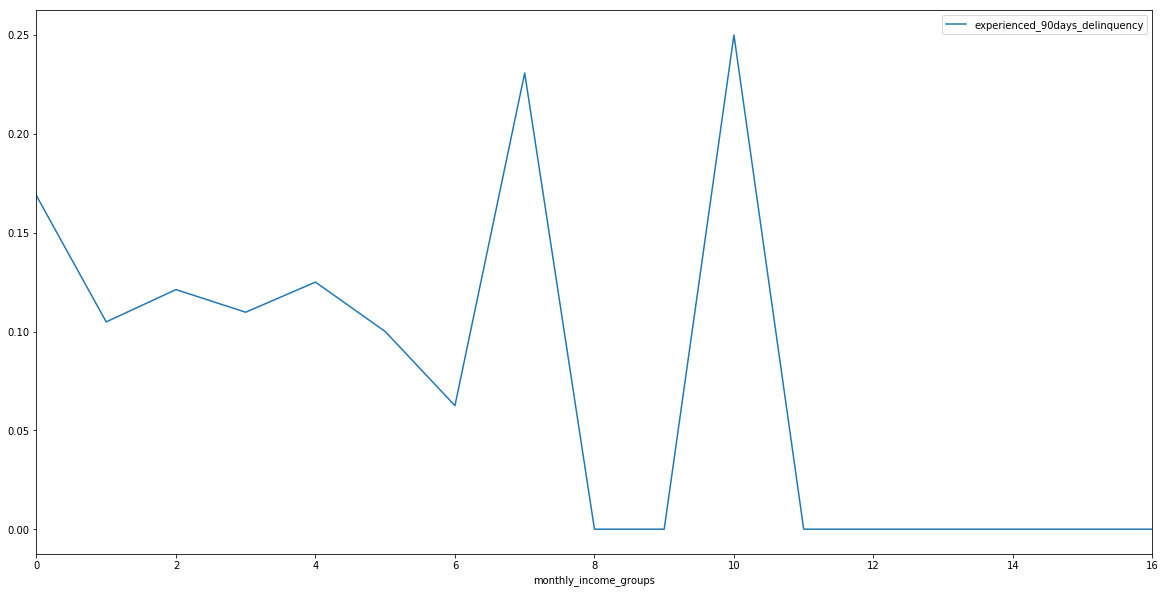

In [67]:
cde.plot_data(clean_credit, 'line', 'monthly_income_groups', 'experienced_90days_delinquency')

Much better graphing with discretized monthly income, which shows an interesting phenomena where income groups at 70,000 and 100,000 show increased probabilites for delinquency. Some of that may be due to how we imputed monthly incomes with the mean.

# 5) Split Data

In [68]:
x_train, x_test, y_train, y_test = kn.split_data(clean_credit, 'experienced_90days_delinquency', 0.4)

In [74]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(24609, 9)
(16407, 9)
(24609, 1)
(16407, 1)


The split worked, as the x_train and y_train dataframes match in shape, as do x_test and y_test.

# 6) Build and Evaluate Classifier

In [85]:
kn.k_neighbors_model(x_train, x_test, y_train, y_test)

/Users/mariomoreno/Desktop/Grad School/Machine Learning/Week 2/knearest_pipeline.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  for weight in weights:


Accuracy      0.847443
Metric       manhattan
Neighbors            9
Weight         uniform
Name: 66, dtype: object

I built a k-nearest-neighbor machine learning algorithm that looped through 1-10 nearest neighbors, four different methods (euclidean, manhattan, chebyshev, minkowski), and two weights.

What it returns is the most accurate model, which consists of an accuracy rate of 0.847443 using the 9 nearest neighbors, manhattan metric, and uniform weights. 

However, from our original data exploration, it was determined that roughly 16% of the population in the data experienced financial distress and 84% did not. Had we built a classifier that assigned a predicted outcome of no distress, it would have performed roughly as well as the best model from our k-nearest neighbor algorithm.